# Data Preprocessing

## Load Data

In [6]:
import os

# Define the HuggingFace repository and local path
ct_filename = "ct.nii.gz"
pancreas_segmentations_filename = "segmentations/pancreas.nii.gz"

data_folder = "./data"
encoded_images_dir = os.path.join(data_folder, "encoded_imgs")

os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl')
import pickle

with open(os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl'), 'rb') as f:
    enc_healthy_cubes = pickle.load(f)

with open(os.path.join(encoded_images_dir, 'enc_pancreatic_tumor_cubes.pkl'), 'rb') as f:
    enc_pancreatic_tumor_cubes = pickle.load(f)

In [7]:
len(enc_healthy_cubes.values())

42

## Unfortunately some of the CTs have less than 10 samples bcs. they ended up being out of range

- [ ] TODO Reduce to min. no. samples of all CTs

In [8]:
import torch

def process_and_stack_tensors(enc_tumor_cubes):
    """
    Process the tensors in the dictionary:
    1. Stack the tensors, ignoring empty lists.
    2. Take tensors with at least 5 entries along the first dimension.
    3. Threshold them to 5 entries, dropping those with fewer than 5 entries.
    4. Stack all the processed tensors along a new axis.
    5. Return the final tensor and the corresponding keys.

    Parameters:
    enc_tumor_cubes (dict): The input dictionary with lists of tensors.

    Returns:
    final_tensor (torch.Tensor): A tensor with all the processed tensors stacked along a new axis.
    valid_keys (list): A list of keys corresponding to the tensors in the final tensor.
    """
    filtered_and_reduced_tensors = []
    valid_keys = []

    for key, inner_list in enc_tumor_cubes.items():
        if inner_list:
            tensor = torch.stack(inner_list).squeeze(1)
            if tensor.shape[0] >= 5:
                filtered_and_reduced_tensors.append(tensor[:5])
                valid_keys.append(key)

    if filtered_and_reduced_tensors:
        final_tensor = torch.stack(filtered_and_reduced_tensors)
    else:
        final_tensor = torch.tensor([])  # Return an empty tensor if no tensors meet the criteria

    return final_tensor, valid_keys

In [9]:
enc_pancreatic_tensors, panc_patient_ids = process_and_stack_tensors(enc_pancreatic_tumor_cubes)
enc_healthy_tensors, healthy_patient_ids = process_and_stack_tensors(enc_healthy_cubes)

print(enc_pancreatic_tensors.shape)
print(enc_healthy_tensors.shape)

torch.Size([13, 5, 8, 24, 24, 24])
torch.Size([42, 5, 8, 24, 24, 24])


In [10]:
panc_patient_ids

['BDMAP_00000416',
 'BDMAP_00000541',
 'BDMAP_00001646',
 'BDMAP_00001754',
 'BDMAP_00002402',
 'BDMAP_00003326',
 'BDMAP_00003427',
 'BDMAP_00004229',
 'BDMAP_00004231',
 'BDMAP_00004847',
 'BDMAP_00005020',
 'BDMAP_00005070',
 'BDMAP_00005185']

In [11]:
final_tensor = torch.cat([enc_healthy_tensors, enc_pancreatic_tensors], dim=0)
final_tensor.shape

torch.Size([55, 5, 8, 24, 24, 24])

In [12]:
healthy_labels = torch.zeros(enc_healthy_tensors.shape[0])
pancreatic_labels = torch.ones(enc_pancreatic_tensors.shape[0])

final_labels = torch.cat([healthy_labels, pancreatic_labels], dim=0)
final_labels.shape

torch.Size([55])

In [13]:
features = final_tensor
labels = final_labels

## Apply scaling and Flattening

In [14]:
from sklearn.preprocessing import StandardScaler

def flatten_and_scale_features(features):
    """
    Flatten and standardize the features.

    Parameters:
        features (numpy.ndarray): Original features of shape (n_samples, ...).

    Returns:
        numpy.ndarray: Flattened and standardized features of shape (n_samples, n_features_flat).
    """
    n_samples = features.shape[0]
    flattened_features = features.reshape(n_samples, -1)
    scaler = StandardScaler()
    flattened_features_std = scaler.fit_transform(flattened_features)
    return flattened_features_std

In [15]:
# Assuming 'features' is your data of shape (n_samples, 8, 24, 24, 24)
# and 'labels' contains the labels (0 for healthy, 1 for unhealthy)
# Load or generate your 'features' and 'labels' here

# Flatten and scale features
flattened_features_std = flatten_and_scale_features(features)

# Dimensionality Reduction and Clustering

## Function Definitions

In [11]:
def print_results(results, n_clusters_list):
    """
    Print the evaluation results.

    Parameters:
        results (dict): Nested dictionaries containing DataFrames of evaluation metrics.
    """
    for dim_method, dim_results in results.items():
        # Create lists of n_components from the keys and sort them
        n_components_values = sorted([int(k.split('_')[-1]) for k in dim_results.keys()])

        # Initialize DataFrames for ARI and NMI
        ari_df = pd.DataFrame(index=n_clusters_list, columns=n_components_values)
        nmi_df = pd.DataFrame(index=n_clusters_list, columns=n_components_values)

        for n_comp, df in dim_results.items():
            n_components = int(n_comp.split('_')[-1])
            for n_clusters in n_clusters_list:
                ari_value = df.loc[n_clusters, 'Adjusted Rand Index']
                nmi_value = df.loc[n_clusters, 'Normalized Mutual Information']
                ari_df.at[n_clusters, n_components] = ari_value
                nmi_df.at[n_clusters, n_components] = nmi_value

        # Print Adjusted Rand Index Table
        print(f"\nResults for {dim_method} - Adjusted Rand Index:")
        print(ari_df)

        # Print Normalized Mutual Information Table
        print(f"\nResults for {dim_method} - Normalized Mutual Information:")
        print(nmi_df)

    # return results

In [12]:
from tqdm import tqdm  # Import tqdm for progress bars
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import pandas as pd

def cluster_and_evaluate(features, method='kmeans', n_clusters=3, labels=None):
    """
    Perform clustering and evaluate the results.

    Parameters:
        features (numpy.ndarray): Reduced-dimensional features.
        method (str): Clustering method to use ('kmeans' supported).
        n_clusters (int): Number of clusters to form.
        labels (numpy.ndarray): True labels for supervised evaluation.

    Returns:
        dict: Dictionary containing evaluation metrics.
    """
    # Perform clustering
    if method == 'kmeans':
        clustering_model = KMeans(n_clusters=n_clusters, random_state=42)
        clustering_model.fit(features)
        cluster_labels = clustering_model.labels_
    else:
        raise ValueError(f"Unsupported clustering method: {method}")

    # Evaluate clustering
    evaluation = {}
    if labels is not None:
        # Adjusted Rand Index
        ari = adjusted_rand_score(labels, cluster_labels)
        evaluation['Adjusted Rand Index'] = ari
        # Normalized Mutual Information
        nmi = normalized_mutual_info_score(labels, cluster_labels)
        evaluation['Normalized Mutual Information'] = nmi

    return evaluation

def evaluate_clustering(features, labels, dim_reduction_methods=['PCA', 't-SNE', 'UMAP'],
                        n_components_list=None, n_clusters_list=None,
                        clustering_methods=['kmeans'],
                        tsne_param_grid=None,
                        umap_param_grid=None):
    """
    Evaluate clustering performance across different dimensionality reduction and clustering methods.

    Parameters:
        features (numpy.ndarray): Original high-dimensional features.
        labels (numpy.ndarray): True labels (used for supervised evaluation).
        dim_reduction_methods (list): Dimensionality reduction methods to apply.
        n_components_list (iterable): List of n_components values to try for PCA.
        n_clusters_list (iterable): List of n_clusters values to try.
        clustering_methods (list): Clustering methods to apply (default is ['kmeans']).
        tsne_param_grid (dict): Hyperparameter grid for t-SNE.
        umap_param_grid (dict): Hyperparameter grid for UMAP.

    Returns:
        dict: Nested dictionaries containing DataFrames of evaluation metrics.
    """

    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import umap

    def apply_pca(data, n_components):
        pca = PCA(n_components=n_components, random_state=42)
        reduced_data = pca.fit_transform(data)
        explained_variance = pca.explained_variance_ratio_.sum()
        return reduced_data, explained_variance

    def apply_tsne(data, **params):
        tsne = TSNE(random_state=42, method='exact', **params)
        reduced_data = tsne.fit_transform(data)
        return reduced_data

    def apply_umap(data, **params):
        reducer = umap.UMAP(random_state=42, **params)
        reduced_data = reducer.fit_transform(data)
        return reduced_data

    # Initialize results dictionary
    results = {}

    # Set default n_components_list and n_clusters_list if not provided
    if n_components_list is None:
        n_components_list = [2, 5, 10, 20, 50]
    if n_clusters_list is None:
        n_clusters_list = [2, 3, 4, 5, 6, 7, 8]

    # Iterate over dimensionality reduction methods with a progress bar
    for dim_name in dim_reduction_methods:
        # Initialize a nested dictionary to store results
        results[dim_name] = {}

        if dim_name == 'PCA':
            # For PCA, we use n_components_list
            for n_components in tqdm(n_components_list, desc=f"Processing {dim_name}", leave=False):
                # Apply PCA
                reduced_features, explained_variance = apply_pca(features, n_components)
                # Initialize DataFrame for this n_components
                key = f"n_components_{n_components}"
                results[dim_name][key] = pd.DataFrame(
                    index=n_clusters_list,
                    columns=['Adjusted Rand Index', 'Normalized Mutual Information']
                )

                # Iterate over number of clusters
                for n_clusters in tqdm(n_clusters_list, desc=f"n_components={n_components}", leave=False):
                    for method in clustering_methods:
                        # Perform clustering and evaluation
                        evaluation = cluster_and_evaluate(
                            reduced_features,
                            method=method,
                            n_clusters=n_clusters,
                            labels=labels  # Pass labels for supervised evaluation
                        )
                        # Store evaluation metrics
                        results[dim_name][key].loc[n_clusters, 'Adjusted Rand Index'] = evaluation['Adjusted Rand Index']
                        results[dim_name][key].loc[n_clusters, 'Normalized Mutual Information'] = evaluation['Normalized Mutual Information']

        elif dim_name == 't-SNE':
            # Set default tsne_param_grid if not provided
            if tsne_param_grid is None:
                tsne_param_grid = {
                    'perplexity': [30],
                    'learning_rate': [200],
                    'n_iter': [1000],
                    'n_components': [2],
                }
            # Generate all combinations of t-SNE hyperparameters
            param_grid = list(ParameterGrid(tsne_param_grid))
            for params in tqdm(param_grid, desc=f"Processing {dim_name}", leave=False):
                # Apply t-SNE with current hyperparameters
                reduced_features = apply_tsne(features, **params)
                # Create a key based on parameters
                param_str = ';'.join(f"{k}={v}" for k, v in params.items())
                key = f"{param_str}"
                results[dim_name][key] = pd.DataFrame(
                    index=n_clusters_list,
                    columns=['Adjusted Rand Index', 'Normalized Mutual Information']
                )

                # Iterate over number of clusters
                for n_clusters in tqdm(n_clusters_list, desc=f"{key}", leave=False):
                    for method in clustering_methods:
                        # Perform clustering and evaluation
                        evaluation = cluster_and_evaluate(
                            reduced_features,
                            method=method,
                            n_clusters=n_clusters,
                            labels=labels
                        )
                        # Store evaluation metrics
                        results[dim_name][key].loc[n_clusters, 'Adjusted Rand Index'] = evaluation['Adjusted Rand Index']
                        results[dim_name][key].loc[n_clusters, 'Normalized Mutual Information'] = evaluation['Normalized Mutual Information']

        elif dim_name == 'UMAP':
            # Set default umap_param_grid if not provided
            if umap_param_grid is None:
                umap_param_grid = {
                    'n_neighbors': [15],
                    'min_dist': [0.1],
                    'n_components': [2],
                }
            # Generate all combinations of UMAP hyperparameters
            param_grid = list(ParameterGrid(umap_param_grid))
            for params in tqdm(param_grid, desc=f"Processing {dim_name}", leave=False):
                # Apply UMAP with current hyperparameters
                reduced_features = apply_umap(features, **params)
                # Create a key based on parameters
                param_str = ';'.join(f"{k}={v}" for k, v in params.items())
                key = f"{param_str}"
                results[dim_name][key] = pd.DataFrame(
                    index=n_clusters_list,
                    columns=['Adjusted Rand Index', 'Normalized Mutual Information']
                )

                # Iterate over number of clusters
                for n_clusters in tqdm(n_clusters_list, desc=f"{key}", leave=False):
                    for method in clustering_methods:
                        # Perform clustering and evaluation
                        evaluation = cluster_and_evaluate(
                            reduced_features,
                            method=method,
                            n_clusters=n_clusters,
                            labels=labels
                        )
                        # Store evaluation metrics
                        results[dim_name][key].loc[n_clusters, 'Adjusted Rand Index'] = evaluation['Adjusted Rand Index']
                        results[dim_name][key].loc[n_clusters, 'Normalized Mutual Information'] = evaluation['Normalized Mutual Information']

        else:
            raise ValueError(f"Unsupported dimensionality reduction method: {dim_name}")

    return results

## Evaluation 🧪

In [ ]:
pca_results = evaluate_clustering(flattened_features_std, labels, n_components_list=range(2, 54, 2), dim_reduction_methods=['PCA'])

In [155]:
# Further PCA results. Clearly best results for between 34 and 40 components. Run more experiments in that range.
# best_pca_results = evaluate_clustering(flattened_features_std, labels, n_components_list=range(34, 40, 1), dim_reduction_methods=['PCA'])

In [157]:
# The results don't seem to change anything
# save_results_to_excel(best_pca_results, 'best_pca_results.xlsx')

Results saved to best_pca_results.xlsx


In [16]:
tsne_results = evaluate_clustering(flattened_features_std, labels, n_components_list=range(2, 54, 2), dim_reduction_methods=['t-SNE'])

Processing t-SNE:   3%|▎         | 12/468 [00:12<09:37,  1.27s/it]

In [13]:
# Define t-SNE parameter grid
tsne_param_grid = {
    'perplexity': list(range(40, 52, 2)),    # Must be less than n. samples
    'learning_rate': [10],                   # fixed at 10
    'n_iter': [3000],                        # fixed at 3000
    'n_components': list(range(30, 56, 2)),  # 30 to 54 inclusive, increments of 2
}

# Set n_clusters fixed at 7
n_clusters_list = [7]

# Call the function
tsne_best_results = evaluate_clustering(
    features=flattened_features_std,
    labels=labels,
    dim_reduction_methods=['t-SNE'],
    n_clusters_list=n_clusters_list,
    tsne_param_grid=tsne_param_grid
)

Processing t-SNE:   0%|          | 0/78 [00:00<?, ?it/s]/home/alubonj1/scr4_randalburns/DiffTumor/venv-py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing t-SNE:   1%|▏         | 1/78 [00:05<07:37,  5.95s/it]/home/alubonj1/scr4_randalburns/DiffTumor/venv-py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing t-SNE:   3%|▎         | 2/78 [00:11<07:06,  5.61s/it]/home/alubonj1/scr4_randalburns/DiffTumor/venv-py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

In [ ]:
umap_results = evaluate_clustering(flattened_features_std, labels, n_components_list=range(2, 54, 2), dim_reduction_methods=['UMAP'])

In [136]:
# Initialize an empty dictionary to store the merged results
merged_results = {}

# Merge PCA results
merged_results.update(pca_results)

# Merge t-SNE results
merged_results.update(tsne_results)

# Merge UMAP results
merged_results.update(umap_results)

# Now merged_results contains results from all three methods

## Results 📊

Best results occur for PCA(n_components=37) and KMeans(n_clusters=6), with an ARI of 0.513 and NMI of 0.415

In [ ]:
print_results(pca_results, n_clusters_list=range(2, 8))


Results for PCA - Adjusted Rand Index:
         2         4         6         8         10        12        14  \
2  0.105422  0.105422  0.105422   0.16362  0.132286  0.132286  0.132286   
3  0.163203  0.158358  0.138364  0.268685  0.020754  0.110171  0.137151   
4  0.161454  0.224447  0.206023  0.154407  0.086646  0.143533  0.225663   
5  0.054793  0.230545  0.238667   0.25608  0.189553  0.188191  0.276914   
6  0.056264  0.223586  0.223586  0.313787  0.220103  0.222912  0.225116   
7   0.03494  0.206704  0.275968   0.27165  0.087995  0.256775  0.330367   

         16        18        20  ...        34        36        38        40  \
2  0.163027  0.132286  0.132286  ... -0.012354  0.051662 -0.012354 -0.072663   
3  0.148408  0.137151  0.107662  ...  0.144451  0.075999 -0.009909 -0.044438   
4  0.114589  0.180407  0.195068  ...  0.199143 -0.066184   0.00304  0.143533   
5  0.224054  0.039817  0.210131  ...  0.075707  0.501698  0.435102  -0.08382   
6  0.129543  0.132812   0.20837  .

In [ ]:
print_results(tsne_results, n_clusters_list=range(2, 8))


Results for t-SNE - Adjusted Rand Index:
         2         4         6         8         10        12        14  \
2  0.348496 -0.024468 -0.019339 -0.062517 -0.024468   0.07905   0.07905   
3  0.158427 -0.022389  -0.02084 -0.064962  -0.04646  0.017204  0.051047   
4  0.121754  0.025294  -0.01257 -0.082634 -0.066184 -0.006495  0.003843   
5  0.087196   0.02262 -0.024559 -0.043537  0.002619  0.018164 -0.017015   
6   0.05538  0.024676 -0.000516 -0.055303  0.029484  0.002511 -0.018204   
7  0.057078  0.027556   -0.0208 -0.020338  0.042498  0.020171 -0.052773   

         16        18        20  ...        34        36        38        40  \
2   0.07905   0.07905 -0.024468  ... -0.024468   0.07905 -0.024468 -0.024468   
3  0.155519  0.051047  -0.04646  ...   0.17252  0.051047  -0.04646 -0.000363   
4  0.124267  0.025641  0.025641  ...  0.094342  0.124267  0.025641  0.003843   
5  0.129978  0.095708  0.002619  ...  0.034261  0.095708  0.002619 -0.017015   
6  0.051184  0.163967  -0.01503 

In [ ]:
print_results(umap_results, n_clusters_list=range(2, 8))


Results for UMAP - Adjusted Rand Index:
         2         4         6         8         10        12        14  \
2  0.192351   0.16362  0.076649  0.040948  0.040948  0.061754  0.061754   
3   0.09794  0.145803  0.146435  0.156966   0.18606  0.200857  0.200857   
4  0.069605  0.133676  0.073904  0.194103   0.17143  0.196352  0.129246   
5  0.053648  0.084218  0.093677  0.145929  0.173827  0.117848  0.103965   
6  0.038888   0.06793  0.089413  0.096501  0.130077  0.143777  0.108178   
7  0.081612  0.096401  0.111682  0.095118  0.088227  0.074125  0.113087   

         16        18        20  ...        34        36        38        40  \
2  0.082548  0.042989  0.040948  ...  0.042309  0.061754  0.061754  0.082548   
3  0.187155  0.099125  0.206882  ...  0.078272   0.17129  0.158146  0.216583   
4  0.172255  0.142185  0.130533  ...  0.110177  0.165306   0.15581  0.172394   
5  0.177315   0.16164  0.194036  ...  0.126155  0.128671   0.08088  0.151652   
6  0.165327  0.048248  0.168643  

In [87]:
import matplotlib.pyplot as plt

def plot_pca_variance_explained(results):
    """
    Plot the variance explained by PCA for different numbers of components.

    Parameters:
        results (dict): The results dictionary returned by evaluate_clustering.
    """
    if 'PCA' not in results:
        print("PCA results not found in the results dictionary.")
        return

    pca_results = results['PCA']
    n_components = []
    variance_explained = []

    # Extract n_components and variance explained
    for key in sorted(pca_results.keys(), key=lambda x: int(x.split('_')[-1])):
        n = int(key.split('_')[-1])
        var_exp = pca_results[key]['Variance Explained'].iloc[0]  # Same for all n_clusters
        n_components.append(n)
        variance_explained.append(var_exp)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(n_components, variance_explained, marker='o', linestyle='-')
    plt.title('Variance Explained by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained')
    plt.grid(True)
    plt.xticks(n_components)  # Ensure all n_components are shown on x-axis
    plt.show()

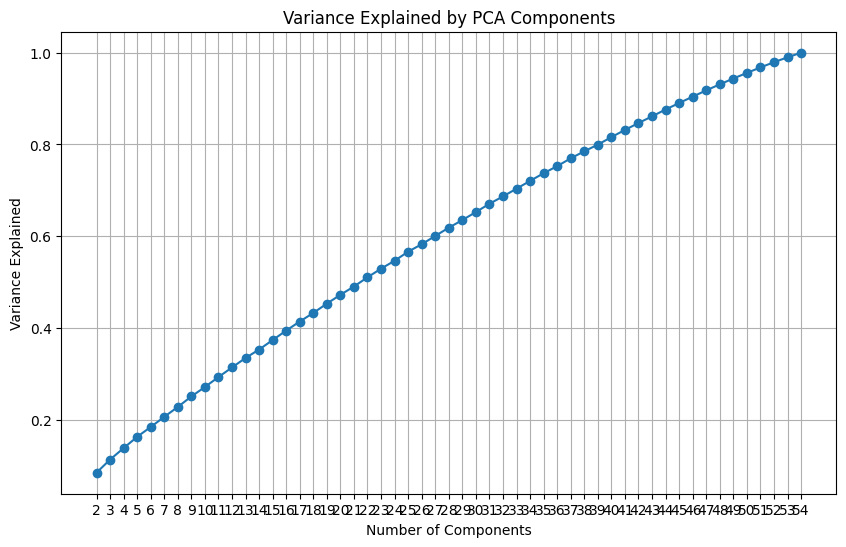

In [90]:
plot_pca_variance_explained(pca_results)

# Plotting

First, perform best clustering - need to find optimal hyperparameters above

<font color='cyan'>From Excel spreadsheet, best choice was: PCA - 36 components - 6 clusters AND T-SNE: 7 clusters, learning_rate	n_components	n_iter	perplexity 10	42	1000	50</font>

In [16]:
from sklearn.decomposition import PCA

best_PCA = PCA(n_components=36, random_state=42)

best_pca_features = best_PCA.fit_transform(flattened_features_std)

In [20]:
from sklearn.cluster import KMeans

best_clustering = KMeans(n_clusters=7, random_state=42)

In [21]:
best_pca_clusters = best_clustering.fit_predict(best_pca_features)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
best_pca_clusters

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 4], dtype=int32)

In [17]:
patient_ids = panc_patient_ids + healthy_patient_ids

In [54]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import colormaps  # Import the correct module for colormaps

# Function to plot 2D scatter plot with annotations and cluster centroids with variance ellipses
def plot_2d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 2D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth labels.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    # Perform PCA to reduce to 2D
    pca_2d = PCA(n_components=2)
    features_2d = pca_2d.fit_transform(features_high_dim)
    
    plt.figure(figsize=(12, 8))
    
    # Define colors for labels
    label_colors = {0: 'blue', 1: 'red'}
    colors = [label_colors[label] for label in labels]
    
    # Plot data points
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=colors, s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    # Add annotations for patient IDs
    for i, patient_id in enumerate(patient_ids):
        plt.annotate(patient_id, (features_2d[i, 0], features_2d[i, 1]), fontsize=8, alpha=0.6)

    # Compute and plot centroids and variance ellipses
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')  # Use the new colormap API without the 'lut' parameter

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_2d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)
        covariance = np.cov(cluster_points, rowvar=False)
        
        if covariance.shape == (2, 2):
            eigenvalues, eigenvectors = np.linalg.eigh(covariance)
            
            # Sort eigenvalues and eigenvectors
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            
            # Compute angle for the ellipse
            angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
            
            # Width and height are "full" widths, so we multiply by 2 to get full length
            width, height = 2 * np.sqrt(eigenvalues)
            
            # Create and add the ellipse patch
            ellipse = Ellipse(xy=centroid, width=width, height=height, angle=angle,
                              edgecolor=cmap(i), facecolor='none', linewidth=2)
            plt.gca().add_patch(ellipse)
        
        # Plot centroid
        plt.scatter(centroid[0], centroid[1], marker='X', s=200, c=[cmap(i)], label=f'Centroid {cluster}')

    # Create legend for labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=10) for label, color in label_colors.items()]
    
    # Create legend for centroids
    centroid_handles = [plt.Line2D([0], [0], marker='X', color='w', label=f'Centroid {cluster}',
                                   markerfacecolor=cmap(i), markersize=10) for i, cluster in enumerate(unique_clusters)]
    
    # Combine both legends
    plt.legend(handles=handles + centroid_handles, loc='best')
    plt.grid(True)
    plt.show()

# Function to plot 3D scatter plot with annotations and cluster centroids
def plot_3d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 3D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth labels.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    # Perform PCA to reduce to 3D
    pca_3d = PCA(n_components=3)
    features_3d = pca_3d.fit_transform(features_high_dim)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define colors for labels
    label_colors = {0: 'blue', 1: 'red'}
    colors = [label_colors[label] for label in labels]
    
    # Plot data points
    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],
                         c=colors, s=50, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')

    # Add annotations for patient IDs
    for i, patient_id in enumerate(patient_ids):
        ax.text(features_3d[i, 0], features_3d[i, 1], features_3d[i, 2], patient_id, size=8, alpha=0.6)
    
    # Compute and plot centroids
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')  # Use the new colormap API without the 'lut' parameter

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_3d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)
        # Plot centroid
        ax.scatter(centroid[0], centroid[1], centroid[2], marker='X', s=200, c=[cmap(i)], label=f'Centroid {cluster}')

    # Create legend for labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=10) for label, color in label_colors.items()]
    
    # Create legend for centroids
    centroid_handles = [plt.Line2D([0], [0], marker='X', color='w', label=f'Centroid {cluster}',
                                   markerfacecolor=cmap(i), markersize=10) for i, cluster in enumerate(unique_clusters)]
    
    # Combine both legends
    ax.legend(handles=handles + centroid_handles, loc='best')
    plt.show()

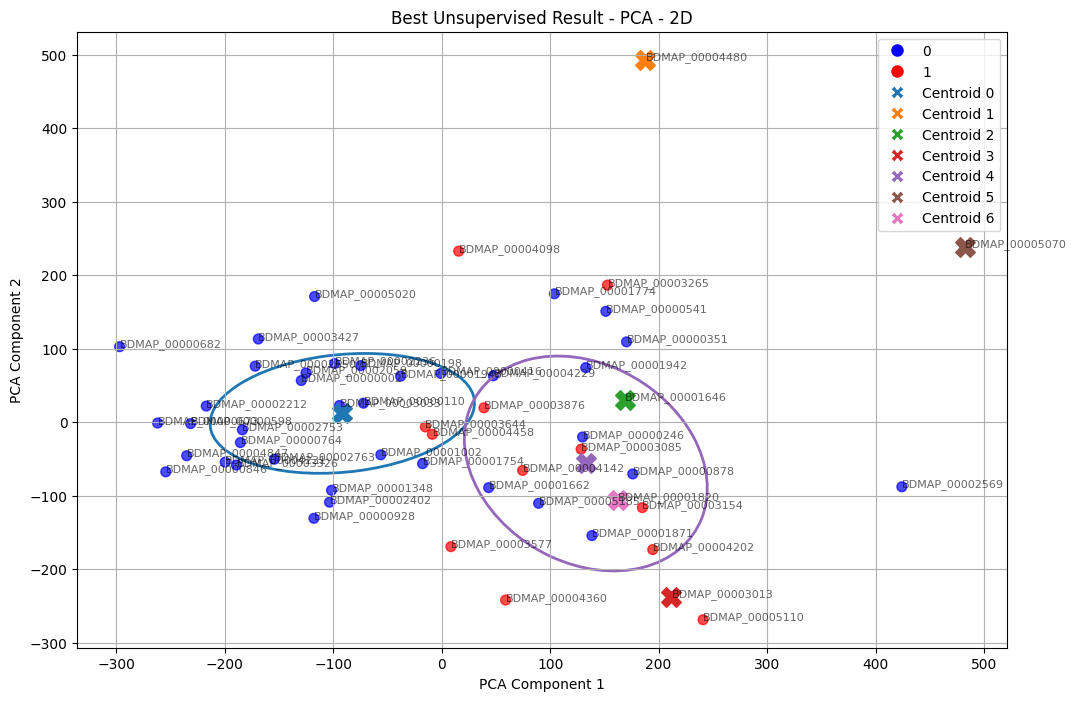

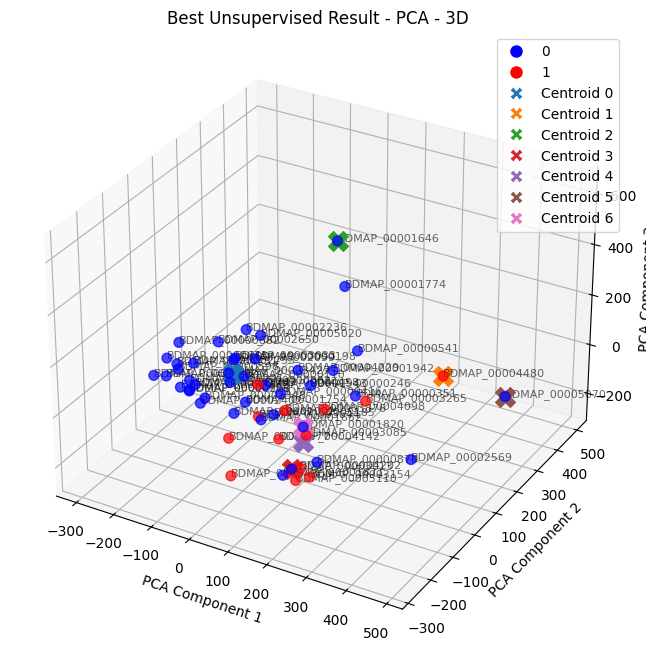

In [57]:
# --- Plotting the Results ---

# Plot the best unsupervised result in 2D
plot_2d(best_pca_features, labels.tolist(), patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_pca_features, labels.tolist(), patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 3D')

# Logistics - Saving to File

In [ ]:
def save_results_to_excel(results, filename):
    """
    Save the clustering evaluation results (Adjusted Rand Index and Normalized Mutual Information)
    to a single Excel sheet with the tables for each dimensionality reduction method stacked vertically,
    3 rows apart.

    Parameters:
        results (dict): Dictionary containing clustering evaluation results.
        filename (str): The output filename for the Excel file.
    """
    import pandas as pd
    from openpyxl import Workbook
    from openpyxl.utils.dataframe import dataframe_to_rows
    from openpyxl.styles import Font

    wb = Workbook()
    ws = wb.active
    ws.title = "Clustering Results"

    current_row = 1  # Start writing from the first row

    # Iterate over each dimensionality reduction method
    for method in results.keys():
        method_results = results[method]

        # Extract n_components and n_clusters
        n_components_list = sorted(int(n_comp.split('_')[-1]) for n_comp in method_results.keys())
        # Assuming 'n_clusters_list' is derived from the index of the first dataframe
        n_clusters_list = sorted(next(iter(method_results.values())).index)

        # Initialize DataFrames for Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI)
        ari_df = pd.DataFrame(index=n_clusters_list)
        nmi_df = pd.DataFrame(index=n_clusters_list)

        # Populate the DataFrames with results
        for n_comp_key, df in method_results.items():
            n_components = int(n_comp_key.split('_')[-1])
            ari_df[n_components] = df['Adjusted Rand Index']
            nmi_df[n_components] = df['Normalized Mutual Information']

        # Ensure the columns are sorted
        ari_df = ari_df[n_components_list]
        nmi_df = nmi_df[n_components_list]

        # ----- Write Adjusted Rand Index (ARI) Table -----
        # Write the title for ARI
        ws.cell(row=current_row, column=1, value=f"Results for {method} - Adjusted Rand Index").font = Font(bold=True)
        current_row += 1  # Move to the next row

        # Write the ARI DataFrame to the worksheet
        for r in dataframe_to_rows(ari_df, index=True, header=True):
            for c_idx, value in enumerate(r, start=1):
                ws.cell(row=current_row, column=c_idx, value=value)
            current_row += 1  # Move to the next row after writing each row of the DataFrame

        # Add a blank row for spacing between ARI and NMI tables
        current_row += 1

        # ----- Write Normalized Mutual Information (NMI) Table -----
        # Write the title for NMI
        ws.cell(row=current_row, column=1, value=f"Results for {method} - Normalized Mutual Information").font = Font(bold=True)
        current_row += 1  # Move to the next row

        # Write the NMI DataFrame to the worksheet
        for r in dataframe_to_rows(nmi_df, index=True, header=True):
            for c_idx, value in enumerate(r, start=1):
                ws.cell(row=current_row, column=c_idx, value=value)
            current_row += 1  # Move to the next row after writing each row of the DataFrame

        # Add 3 blank rows to separate from the next method's tables
        current_row += 3

    # Save the workbook to the specified filename
    wb.save(filename)
    print(f"Results saved to {filename}")

In [ ]:
save_results_to_excel(merged_results, 'unsupervised_clustering_results.xlsx')

Results saved to unsupervised_clustering_results.xlsx


#### Saving to TSV for projector.tensorflow.org

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans

# Assume 'features' and 'labels' are your data and labels
# Flatten and scale features if not already done
scaler = StandardScaler()
features_scaled = scaler.fit_transform(flattened_features_std)

# Apply Supervised UMAP with n_components = 17
n_components = 17
reducer = umap.UMAP(
    n_components=n_components,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)
embedding = reducer.fit_transform(features_scaled, y=labels)

# Perform K-Means clustering with n_clusters = 2
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(embedding)

# Prepare data for TSV files
# Create a DataFrame for the embedding
embedding_df = pd.DataFrame(embedding)

# Add cluster assignments and true labels
embedding_df['Cluster'] = cluster_assignments
embedding_df['Label'] = labels  # Ensure 'labels' is an array-like object

# Save the embedding vectors (without Cluster and Label columns)
embedding_df.drop(columns=['Cluster', 'Label']).to_csv('features.tsv', sep='\t', index=False, header=False)

# Save the metadata (Cluster assignments and Labels)
metadata_df = embedding_df[['Cluster', 'Label']]
metadata_df.to_csv('metadata.tsv', sep='\t', index=False)

# Supervised Clustering

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
def apply_nca(features, labels, n_components):
    """
    Apply Neighborhood Components Analysis (NCA).

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        numpy.ndarray: Transformed features.
    """
    nca = NeighborhoodComponentsAnalysis(n_components=n_components, random_state=42)
    nca.fit(features, labels)
    return nca.transform(features)


def apply_pls(features, labels, n_components):
    """
    Apply Partial Least Squares (PLS) regression.

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of components to keep.

    Returns:
        numpy.ndarray: Transformed features.
    """
    lb = LabelBinarizer()
    labels_binarized = lb.fit_transform(labels)
    pls = PLSRegression(n_components=n_components)
    pls.fit(features, labels_binarized)
    return pls.transform(features)


def apply_supervised_umap(features, labels, n_components, n_neighbors=15, min_dist=0.1):
    """
    Apply Supervised UMAP.

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        numpy.ndarray: Transformed features.
    """
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42
    )
    return reducer.fit_transform(features, y=labels)

In [ ]:
def evaluate_supervised_methods(features, labels):
    """
    Evaluate clustering with supervised dimensionality reduction methods.

    Parameters:
        features (numpy.ndarray): Scaled features.
        labels (numpy.ndarray): Class labels.

    Returns:
        dict: Results for each method.
    """
    n_components_list = list(range(2, min(features.shape[1], 56), 5))
    n_clusters_list = list(range(2, 8))
    dim_reduction_methods = ['NCA', 'PLS', 'Supervised UMAP']
    clustering_methods = ['kmeans', 'agglomerative', 'gmm']
    
    results = {}
    
    for method in dim_reduction_methods:
        print(f"\nDimensionality Reduction Method: {method}")
        results[method] = {}
        for n_components in n_components_list:
            print(f"  n_components = {n_components}")
            if method == 'NCA':
                try:
                    transformed_features = apply_nca(features, labels, n_components)
                except Exception as e:
                    print(f"    NCA failed at n_components={n_components}: {e}")
                    continue
            elif method == 'PLS':
                try:
                    transformed_features = apply_pls(features, labels, n_components)
                except Exception as e:
                    print(f"    PLS failed at n_components={n_components}: {e}")
                    continue
            elif method == 'Supervised UMAP':
                transformed_features = apply_supervised_umap(features, labels, n_components)
            
            results_key = f"n_components_{n_components}"
            results[method][results_key] = pd.DataFrame(
                index=n_clusters_list,
                columns=clustering_methods
            )
            
            for n_clusters in n_clusters_list:
                for cluster_method in clustering_methods:
                    evaluation = cluster_and_evaluate(
                        transformed_features,
                        method=cluster_method,
                        n_clusters=n_clusters
                    )
                    # Store Silhouette Score
                    results[method][results_key].loc[n_clusters, cluster_method] = evaluation['Silhouette Score']
        print("  Evaluation complete.")
    return results

In [ ]:
supervised_results = evaluate_supervised_methods(flattened_features_std, labels)


Dimensionality Reduction Method: NCA
  n_components = 2
  n_components = 7
  n_components = 12
  n_components = 17
  n_components = 22
  n_components = 27
  n_components = 32
  n_components = 37
  n_components = 42
  n_components = 47
  n_components = 52
  Evaluation complete.

Dimensionality Reduction Method: PLS
  n_components = 2
  n_components = 7
  n_components = 12
  n_components = 17
  n_components = 22
  n_components = 27
  n_components = 32
  n_components = 37
  n_components = 42
  n_components = 47
  n_components = 52
  Evaluation complete.

Dimensionality Reduction Method: Supervised UMAP
  n_components = 2
  n_components = 7
  n_components = 12
  n_components = 17
  n_components = 22
  n_components = 27
  n_components = 32
  n_components = 37
  n_components = 42
  n_components = 47
  n_components = 52
  Evaluation complete.


In [ ]:
for method, n_components_dict in supervised_results.items():
    print(f"\nResults for {method}:\n")
    for n_components, df in n_components_dict.items():
        print(f"{n_components}")
        print(df)
        print("\n")


Results for NCA:

n_components_2
     kmeans agglomerative       gmm
2  0.415781      0.403015  0.412469
3  0.471768      0.435367  0.471768
4   0.42468      0.325491  0.207349
5  0.372024      0.324841  0.187038
6  0.369312      0.364407  0.176826
7  0.378918      0.365611  0.268334


n_components_7
     kmeans agglomerative       gmm
2  0.197427      0.178406  0.247093
3  0.196978      0.186267  0.243406
4  0.207885      0.210924  0.215972
5  0.235804       0.23825  0.091066
6  0.222924      0.260684  0.091944
7  0.245807      0.264427  0.100665


n_components_12
     kmeans agglomerative       gmm
2  0.128265      0.125084   0.18264
3   0.13986      0.129365 -0.040489
4  0.152924      0.130982 -0.005983
5  0.138891      0.133962  0.000402
6  0.143016      0.156038  0.006684
7  0.147451      0.154797  0.009358


n_components_17
     kmeans agglomerative       gmm
2  0.101461      0.135077  0.112626
3    0.1046      0.135731  0.115402
4  0.136785      0.136128  0.083596
5  0.088546  

Based on the Silhouette Scores, the best clustering result is:

	•	Dimensionality Reduction Method: Supervised UMAP
	•	Number of Components (n_components): 17
	•	Clustering Method: K-Means
	•	Number of Clusters (n_clusters): 2
	•	Silhouette Score: 0.959937


Saving that as a TSV for Projector.tensorflow.org